# Modelo de tarifación Airbnb en New York

Modificado en Nov 3, 2020

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models, layers, optimizers, regularizers
from numpy.random import seed
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
import math
import numpy as np
seed(123)
print(tf.__version__)

2.1.0


## Dataset de entrada

In [2]:
dataset=pd.read_csv('C:\\Users\\Andrea\\Desktop\\Datasets\\Airbnb NY\\Listings_clean.csv')
print('El dataset de entrada contiene', len(dataset.columns), 'columnas', 'y', len(dataset), 'filas')

El dataset de entrada contiene 32 columnas y 35113 filas


In [3]:
dataset=dataset[(dataset['price']<1000) & (dataset['price']>0)]

In [4]:
dataset.shape

(34954, 32)

In [5]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(dataset)

,Unnamed: 0,id,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bathrooms_text,amenities,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,instant_bookable,calculated_host_listings_count,reviews_per_month,Apartment,House,Other,Room,Entire home/apt,Private room,Shared room,Private,Shared
0,0,2595,0.0,6.0,1.0,1.0,40.75362,-73.98377,2,1 bath,"[""Iron"", ""Cleaning before checkout"", ""Extra pi...",175.0,3,1125,1,30,60,90,365,48,0,2,0.37,1,0,0,0,1,0,0,1,0
1,1,3831,0.0,1.0,1.0,1.0,40.68514,-73.95976,3,1 bath,"[""Iron"", ""Extra pillows and blankets"", ""Smoke ...",76.0,1,730,1,13,30,51,272,349,0,1,4.82,0,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35111,45613,45250981,0.0,1.0,1.0,1.0,40.77081,-73.92718,2,1 bath,"[""Laptop-friendly workspace"", ""Carbon monoxide...",83.0,3,10,1,5,5,5,5,1,0,1,1.00,1,0,0,0,1,0,0,1,0
35112,45695,45290019,1.0,11.0,1.0,1.0,40.65846,-73.96106,3,1 bath,"[""Laptop-friendly workspace"", ""Iron"", ""Carbon ...",79.0,1,30,1,26,56,85,85,1,1,1,1.00,1,0,0,0,1,0,0,1,0


In [6]:
dataset.columns

Index(['Unnamed: 0', 'id', 'host_is_superhost', 'host_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'latitude',
       'longitude', 'accommodates', 'bathrooms_text', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'instant_bookable',
       'calculated_host_listings_count', 'reviews_per_month', 'Apartment',
       'House', 'Other', 'Room', 'Entire home/apt', 'Private room',
       'Shared room', 'Private', 'Shared'],
      dtype='object')

In [7]:
dataset=dataset.drop(['Unnamed: 0', 'id','bathrooms_text','amenities'], axis=1)
dataset=dataset.drop(['availability_60', 'availability_90','availability_365','Private', 'reviews_per_month', 'Private room', 
                      'calculated_host_listings_count','Shared room'], axis=1)

In [8]:
dataset['price']=np.log(dataset['price'])

## Dividiendo los datos en entrenamiento y testing

In [9]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## Descriptivo

In [10]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
host_is_superhost,27963.0,0.242964,4.288811e-01,0.000000,0.000000,0.00000,0.000000,1.000000e+00
host_listings_count,27963.0,7.499088,6.964137e+01,0.000000,1.000000,1.00000,2.000000,1.916000e+03
host_has_profile_pic,27963.0,0.997211,5.274200e-02,0.000000,1.000000,1.00000,1.000000,1.000000e+00
host_identity_verified,27963.0,0.783714,4.117187e-01,0.000000,1.000000,1.00000,1.000000,1.000000e+00
latitude,27963.0,40.728791,5.585294e-02,40.508680,40.688460,40.72304,40.763590,4.091169e+01
longitude,27963.0,-73.949530,4.843493e-02,-74.239860,-73.982220,-73.95439,-73.932585,-7.371299e+01
accommodates,27963.0,2.806709,1.787493e+00,1.000000,2.000000,2.00000,4.000000,1.600000e+01
price,27963.0,4.623750,6.448545e-01,2.302585,4.174387,4.60517,5.017280,6.906755e+00
minimum_nights,27963.0,7.305439,2.132956e+01,1.000000,2.000000,3.00000,5.000000,1.250000e+03
maximum_nights,27963.0,78087.683475,1.284271e+07,1.000000,29.000000,365.00000,1125.000000,2.147484e+09


## Normalizando

In [11]:
def min_max(x): 
    return (x-x.min())/(x.max()-x.min())

In [12]:
normed_train_data = min_max(train_dataset)
normed_test_data = min_max(test_dataset)

In [13]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(normed_test_data)

,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,price,minimum_nights,maximum_nights,has_availability,availability_30,number_of_reviews,instant_bookable,Apartment,House,Other,Room,Entire home/apt,Shared
10,0.0,0.000522,1.0,1.0,0.479508,0.500143,0.133333,0.529591,0.002747,4.450000e-06,1.0,0.000000,0.278207,0.0,1.0,0.0,0.0,0.0,1.0,0.0
11,1.0,0.001566,1.0,1.0,0.688678,0.512274,0.066667,0.696556,0.008242,3.495000e-05,1.0,1.000000,0.358578,1.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35098,0.0,0.000000,1.0,0.0,0.802827,0.703302,0.133333,0.474271,0.000000,1.820000e-05,1.0,0.733333,0.001546,1.0,1.0,0.0,0.0,0.0,1.0,0.0
35110,0.0,0.000000,1.0,1.0,0.342653,0.441761,0.066667,0.341741,0.000000,7.000000e-07,1.0,0.633333,0.000000,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [14]:
train_stats = normed_train_data.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
host_is_superhost,27963.0,0.242964,0.428881,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.0
host_listings_count,27963.0,0.003914,0.036347,0.0,5.219207e-04,5.219207e-04,1.043841e-03,1.0
host_has_profile_pic,27963.0,0.997211,0.052742,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.0
host_identity_verified,27963.0,0.783714,0.411719,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.0
latitude,27963.0,0.546168,0.138589,0.0,4.460931e-01,5.318975e-01,6.325153e-01,1.0
longitude,27963.0,0.551047,0.091930,0.0,4.890011e-01,5.418225e-01,5.832084e-01,1.0
accommodates,27963.0,0.120447,0.119166,0.0,6.666667e-02,6.666667e-02,2.000000e-01,1.0
price,27963.0,0.504144,0.140059,0.0,4.065450e-01,5.001087e-01,5.896166e-01,1.0
minimum_nights,27963.0,0.005048,0.017077,0.0,8.006405e-04,1.601281e-03,3.202562e-03,1.0
maximum_nights,27963.0,0.000036,0.005980,0.0,1.303852e-08,1.695007e-07,5.234033e-07,1.0


# Separando caracteristicas y etiquetas

In [15]:
train_labels = normed_train_data.pop('price')
test_labels = normed_test_data.pop('price')

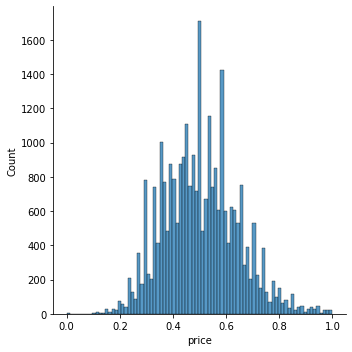

In [16]:
sns.displot(train_labels)

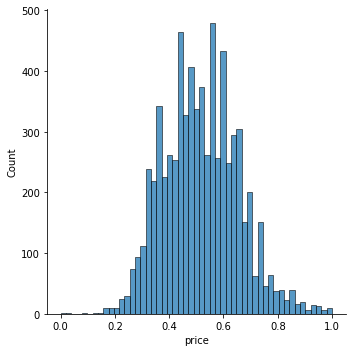

In [17]:
sns.displot(test_labels)

# El modelo

### Construye el modelo

In [18]:
# ,kernel_regularizer=regularizers.l2(0.05)
# La mejor que llevo es 256, 128, 16, dropout 0.1 y sin regularizador
def build_model():  
  model = keras.Sequential([
    layers.Dense(256, activation='relu',input_shape=[len(normed_train_data.keys())]),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    #layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
  ])

  optimizer=Adam(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [19]:
model = build_model()

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               5120      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 42,177
Trainable params: 42,177
Non-trainable params: 0
____________________________________________________

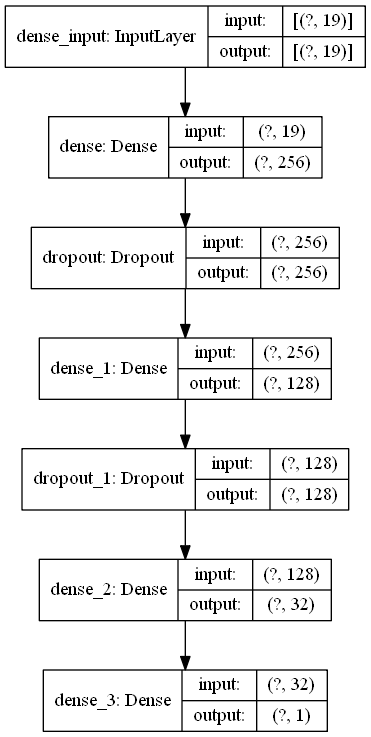

In [21]:
plot_model(model, to_file='regresion_model_keras.png', show_shapes=True)

In [22]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.21574846],
       [0.20233542],
       [0.1542114 ],
       [0.16881415],
       [0.16400525],
       [0.15090925],
       [0.20829582],
       [0.19458899],
       [0.14480568],
       [0.14513698]], dtype=float32)

### Entrenamiento del modelo

In [23]:
# Display training progress by printing a single dot for each completed epoch
time_start = time.time()

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 250

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

time_end = time.time()
print(f"\nTiempo de ejecución: {round((time_end - time_start)/60,1)} minutos")


....................................................................................................
....................................................................................................
..................................................
Tiempo de ejecución: 10.2 minutos


In [24]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
245,0.006494,0.061512,0.006494,0.007062,0.064284,0.007062,245
246,0.006546,0.061549,0.006546,0.007123,0.065195,0.007123,246
247,0.006502,0.061455,0.006502,0.007030,0.064565,0.007030,247
248,0.006500,0.061332,0.006500,0.007055,0.064354,0.007055,248
249,0.006534,0.061625,0.006534,0.006957,0.064020,0.006957,249


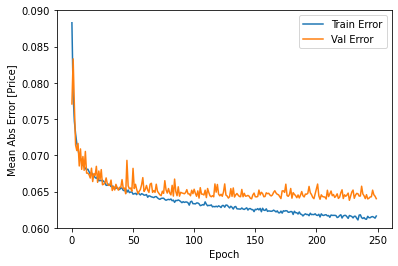

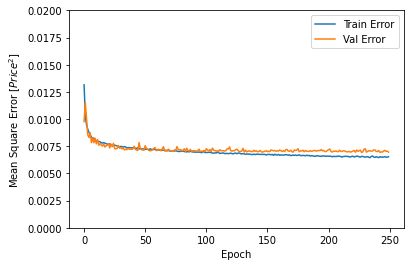

In [25]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Ln(Price)]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0.06,0.085])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$Price^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0.0,0.02])
  plt.legend()
  plt.show()


plot_history(history)


...............................................................

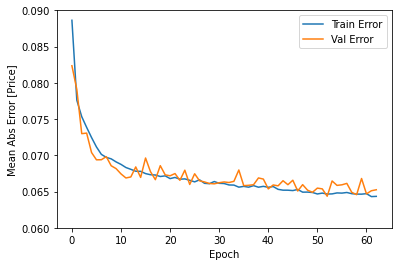

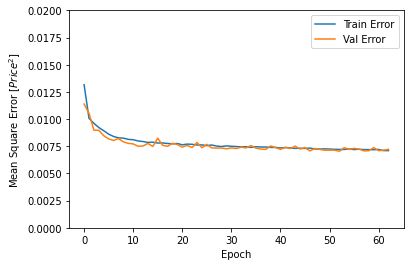

In [26]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [27]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f}".format(mae))

6991/6991 - 0s - loss: 0.0073 - mae: 0.0641 - mse: 0.0073
Testing set Mean Abs Error:  0.06


## Predicciones

6991


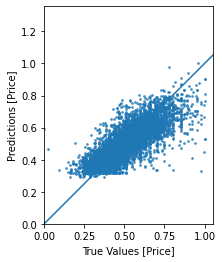

In [28]:
test_predictions = model.predict(normed_test_data).flatten()
print(len(test_predictions))
plt.scatter(test_labels, test_predictions,alpha=0.7,s=3)
plt.xlabel('True Values [Price]')
plt.ylabel('Predictions [Price]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-10, 10], [-10, 10]) #El modelo subestima para precios mayores a 200 dolares

6991


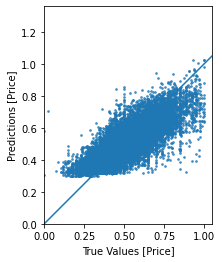

In [29]:
train_predictions = model.predict(normed_train_data).flatten()
print(len(test_predictions))
plt.scatter(train_labels, train_predictions,alpha=0.7,s=3)
plt.xlabel('True Values [Price]')
plt.ylabel('Predictions [Price]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-10, 10], [-10, 10])

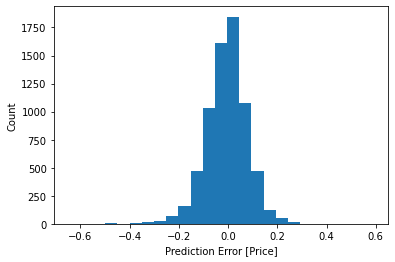

In [30]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Price]")
_ = plt.ylabel("Count")

In [31]:
y_test_pred = model.predict(normed_test_data)
y_train_pred = model.predict(normed_train_data)
print("Training MSE:", round(mean_squared_error(train_labels, y_train_pred),4))
print("Validation MSE:", round(mean_squared_error(test_labels, y_test_pred),4))
print("\nTraining r2:", round(r2_score(train_labels, y_train_pred),4))
print("Validation r2:", round(r2_score(test_labels, y_test_pred),4))

Training MSE: 0.0068
Validation MSE: 0.0073

Training r2: 0.6535
Validation r2: 0.6175


In [37]:
math.exp(0.0068)

1.0068231724945438